### Simple linear example

#### Simple case where we trade equal quantities

$P_{t+1} = P_t + \sigma \epsilon_t + \alpha \frac{q_t}{V_t}$

- $P_t$: Asset price at time t
- $ \sigma \epsilon_t$: Random price fluctuation due to market volatility
- $\alpha$: Market impact sensitivity
- $q_t$: Quantity of shares traded at time t
- $V_t$: Average trading volume (assumed constant for simplicity)

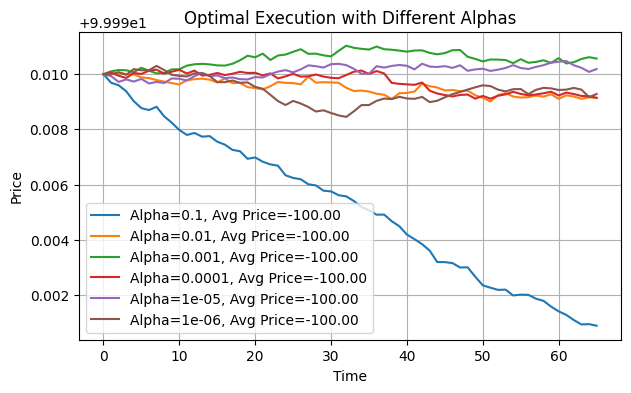

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
P_0 = 100  # initial price
Q = 10000  # total quantity to trade
T = 65  # time horizon
alphas = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]  # different market impact sensitivities
sigma = 0.0001  # price volatility
V_t = 100000  # average trading volume (constant)

def simulate_execution(alpha, Q, T, P_0, sigma, V_t):
    q_t = -(Q / T)  # naive strategy: trade equal quantities
    prices = [P_0]
    remaining_qty = Q
    total_cost = 0
    
    for t in range(T):
        # Update price with market impact
        price_impact = alpha * (q_t / V_t)
        P_t = prices[-1] + price_impact + np.random.normal(0, sigma)
        prices.append(P_t)
        
        # Trade and update remaining quantity
        total_cost += P_t * q_t
        remaining_qty -= q_t
    
    avg_price = total_cost / Q
    return prices, remaining_qty, avg_price

# Simulate for different alphas
plt.figure(figsize=(7, 4))
for alpha in alphas:
    prices, remaining_qty, avg_price = simulate_execution(alpha, Q, T, P_0, sigma, V_t)
    plt.plot(range(T + 1), prices, label=f'Alpha={alpha}, Avg Price={avg_price:.2f}')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Optimal Execution with Different Alphas')
plt.legend()
plt.grid(True)
plt.show()


### Almgren-Chriss Optimal Execution Model

The aim of the Almgren-Chriss optimal execution model is to minimize a combination of volatility risk and transaction costs arising from permanent and temporary market impact. In this notebook, we study the model for liquidation of large positions with real financial data.

Based on Almgren, R. and Chriss, N., 2001. Optimal execution of portfolio transactions. The Journal of Risk, 3(2), pp.5-39.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Google Data

In [2]:
goog = yf.Ticker('GOOG')
data = goog.history(period='3mo')
display(data)

/Users/fzejnu/Library/Python/3.9/lib/python/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-10 00:00:00-04:00,169.497127,171.145245,167.719151,170.096436,18740500,0.0,0.0
2024-05-13 00:00:00-04:00,165.658484,170.755680,165.571577,170.705734,19648600,0.0,0.0
2024-05-14 00:00:00-04:00,171.394963,172.583613,170.226295,171.734573,18729500,0.0,0.0
2024-05-15 00:00:00-04:00,172.104152,173.848169,171.834455,173.682358,20958200,0.0,0.0
2024-05-16 00:00:00-04:00,174.401548,176.139560,173.852170,175.230591,17247300,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-05 00:00:00-04:00,157.369995,165.940002,156.600006,160.639999,34907800,0.0,0.0
2024-08-06 00:00:00-04:00,160.945007,162.350006,158.130005,160.539993,36146500,0.0,0.0
2024-08-07 00:00:00-04:00,163.240005,164.789993,160.240005,160.750000,19334200,0.0,0.0


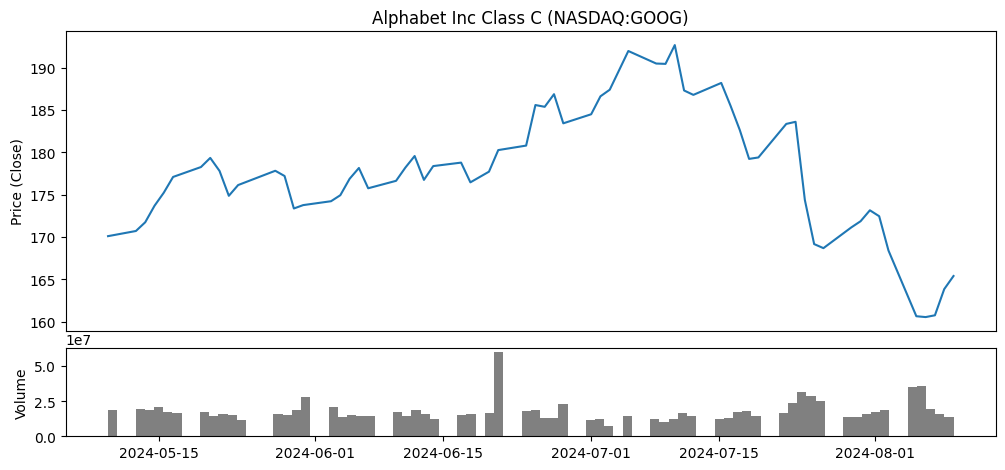

In [17]:
top_plt = plt.subplot2grid((6,2), (0, 0), rowspan=3, colspan=4)
top_plt.plot(data.index, data["Close"])
top_plt.set_ylabel('Price (Close)')
top_plt.set_xticks([])
plt.title('Alphabet Inc Class C (NASDAQ:GOOG)')
bottom_plt = plt.subplot2grid((6,2), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(data.index, data['Volume'], width=1, color="grey")
bottom_plt.set_ylabel('Volume')
plt.gcf().set_size_inches(12,8)

### Parameter Calibration

Let $X$ be the initial position. We wish to liquidate, setting our position to 0. Let $T$ be the time we have to liquidate.

- $\lambda$ is a risk-aversion parameter. The smaller $\lambda$ is, the more risk the agent is willing to take.
- $\sigma$ is a measure of the volatility of the asset. It is the standard deviation of the daily price. For the sake of this example, we compute $\sigma$ using the data of future prices for a trading strategy in the past. This would not be possible in real implementations where $\sigma$ would have to be estimated.
- $\epsilon$ is a temporary market impact parameter. It is calibrated as half of the average bid/ask spread plus fees. Again, in real implementations, we cannot know the future spread, hence $\epsilon$ would have to be estimated. 
- $\eta$ is another temporary market impact parameter. It depends on internal and transient aspects of the market microstructure. This makes it hard to approximate. It is in this term that we would expect non-linear effects to be most important.
- $\gamma$ is a permanent market impact parameter. Assuming linear market impact, each $n$ units that the agent sells, depresses the price per unit by $\gamma n$.
- $\tau = \frac{T}{N}$ is the size of the period in which we can make an order i.e. the agent can trade at each time $t_k = k\tau$ for $k=0,...,N$. In this example, we take $\tau$ to be one day which means we can make an order each day. 

We use the daily closing price as the daily price of the asset.

We calibrate $\eta$ and $\gamma$ as 

$$\eta = \frac{\text{Spread}}{0.01 \times \text{Avg. Daily Volume}}$$

$$\gamma = \frac{\text{Spread}}{0.1 \times \text{Avg. Daily Volume}}$$


In [3]:
average_daily_volume = np.mean(data['Volume'])
average_daily_spread = np.mean(data['High'] - data['Low'])

sigma = np.std(data['Close'])
epsilon = average_daily_spread/2
eta = average_daily_spread/(0.01*average_daily_volume)
gamma = average_daily_spread/(0.1*average_daily_volume)
tau = 1

params = {
    'lambda': 1e-08,
    'sigma': sigma,
    'epsilon': epsilon,
    'eta': eta,
    'gamma': gamma,
    'tau': tau
}

print('Parameters:')
for k,v in params.items():
    print('  {} = {}'.format(k,v))

Parameters:
  lambda = 1e-08
  sigma = 7.461607904747447
  epsilon = 1.704568652330602
  eta = 1.907558118895873e-05
  gamma = 1.9075581188958734e-06
  tau = 1


### Implementation

A trading trajectory is a vector $(x_0,..,x_N)$ where $x_k$ is the number of units of the asset that the agent plans to hold at time $t_k$. Given $\lambda$, $\sigma$, $\epsilon$, $\eta$, $\gamma$, and $\tau$, we can compute the optimal trading trajectory $(x_0,..,x_N)$ for initial position $X$ and time-to-liquidate $T$ with the following equations:

$$\tilde{\eta} = \eta - \frac{\gamma \tau}{2}$$

$$\tilde{\kappa}^2 = \frac{\lambda \sigma^2}{\tilde{\eta}}$$

$$\frac{2}{\tau^2}\left(\cosh(\kappa \tau) - 1\right) = \tilde{\kappa}^2 \iff \kappa = \frac{1}{\tau}\text{arccosh}\left(\frac{\tilde{\kappa}^2 \tau^2}{2} + 1\right)$$

$$x_k = \frac{\sinh(\kappa(T-t_k))}{\sinh(\kappa T)}X, \quad k = 0,...,N$$

In [23]:
class AlmgrenChriss1D:
    
    def __init__(self, params):
        # Initialize Parameters
        self._lambda = params['lambda']
        self._sigma = params['sigma']
        self._epsilon = params['epsilon']
        self._eta = params['eta']
        self._gamma = params['gamma']
        self._tau = params['tau']
        
        self._eta_tilda = self._eta - 0.5*self._gamma*self._tau
        
        # Ensure Quadratic (for optimization)
        #assert self._eta_tilda > 0


        
        self._kappa_tilda_squared = (self._lambda*self._sigma**2)/self._eta_tilda


        arg_for_arccosh = 0.5 * (self._kappa_tilda_squared * self._tau**2) + 1
        if arg_for_arccosh >= 1:
            self._kappa = np.arccosh(arg_for_arccosh) / self._tau
        else:
            raise ValueError(f"Invalid value for arccosh: {arg_for_arccosh}. Must be >= 1.")
        
        self._kappa = np.arccosh(0.5*(self._kappa_tilda_squared*self._tau**2) + 1)/self._tau
        
    def trajectory(self, X, T):
        # Optimal Liquidation Trajectory
        ans = []
        for t in range(T):
            x = int(np.sinh(self._kappa*(T - t))/np.sinh(self._kappa*T)*X)
            ans.append(x)
        ans.append(0)
        return np.array(ans)
    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X,T))

### Optimal Trajectory Sensitivity

#### Risk-Aversion

Explore different values of $\lambda$.

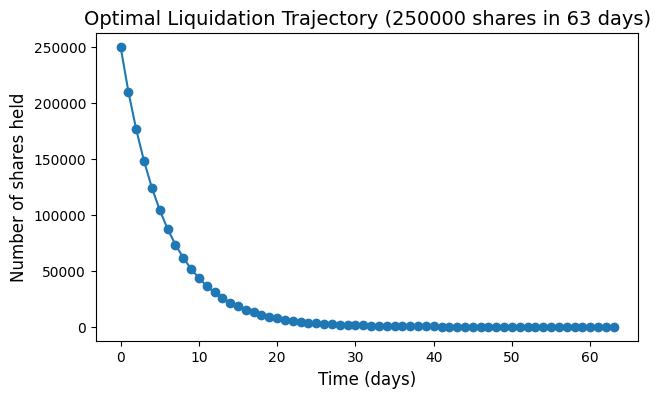

In [24]:
X = 250000
T = len(data)

model = AlmgrenChriss1D(params)
trajectory = model.trajectory(X,T)

plt.figure(figsize=(7,4))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()

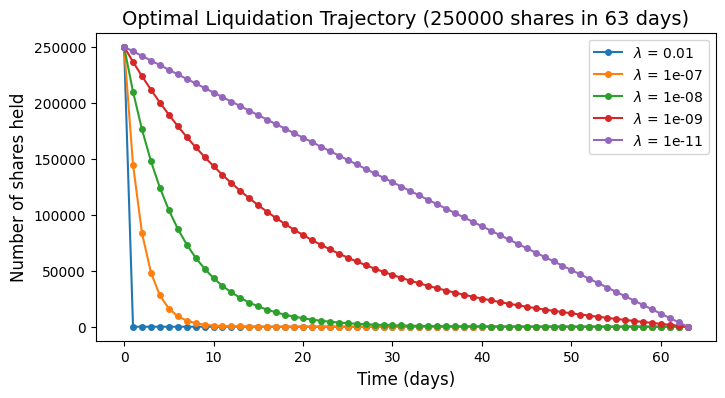

In [25]:
lambdas = [1e-2, 1e-7, 1e-8, 1e-9, 1e-11]

plt.figure(figsize=(8,4))
for _lambda in lambdas:
    new_params = params.copy()
    new_params['lambda'] = _lambda
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\lambda$ = {_lambda}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

When $\lambda$ is closer to 0, the optimal trajectory approches an eqaul-sized packet trajectory in which the agent sells the same amount of shares each day. In this case, the agent does not care about the risk, the transaction costs are reduced since trade volumes are much smaller, and the variance of the total trading cost increases.

When $\lambda$ is further away from 0, the optimal trajectory involves selling most of the shares during the first days since the agent does not want to take on the risk of holding them for too long. In this case, the transaction cost would be huge due to a big market impact, but the strategy leads to a low the variance of the total trading cost.

#### Permanent Market Impact

We explore different values of $\gamma$.

In [28]:
gammas = [0.0001,0.002,0.005,0.008]

plt.figure(figsize=(12,7))
for gamma in gammas:
    new_params = params.copy()
    new_params['gamma'] = gamma
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\gamma$ = {gamma}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

ValueError: Invalid value for arccosh: 0.9909981182080759. Must be >= 1.

<Figure size 1200x700 with 0 Axes>

When $\gamma$ is larger, the optimal trading strategy involves selling more shares earlier leading to higher transaction costs but lower variance of the total trading cost. Since larger $\gamma$ means more permanent market impact, it is optimal to sell the shares quickly, instead of holding on to the shares with impacted prices.

#### Temporary Market Impact
We explore different values of $\eta$.

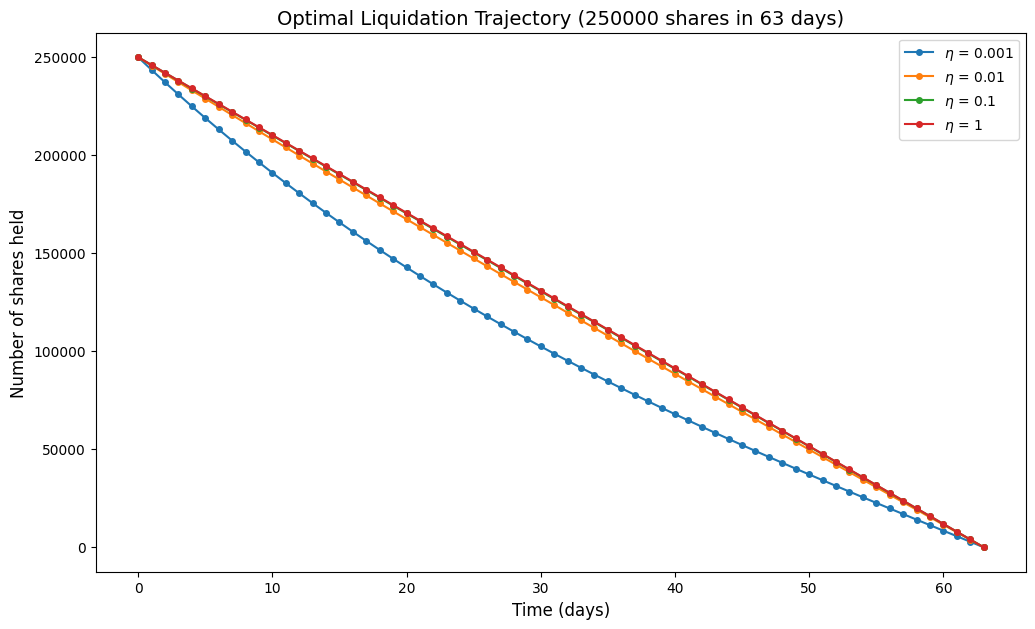

In [26]:
etas = [0.001,0.01,0.1,1]

plt.figure(figsize=(12,7))
for eta in etas:
    new_params = params.copy()
    new_params['eta'] = eta
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\eta$ = {eta}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

When $\eta$ is larger, the optimal trading trajectory approches the equal-packet trajectory. Larger $\eta$ means that there is more temporary market impact. This means that if you sell a large amount on a given day, the price of the asset would fall on that day (but recover the next day since it's a temporary impact). This means that is is optimal to sell only a small amount each day and wait for the price to recover if temporary market impact is high.

Furthermore, the optimal trading trajectory does not vary with $\epsilon$. However, the expected value of the total trading cost increases linearly with $\epsilon$.